In [2]:
#Import the neccassary libraries. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Checklist: 
- Temperature vs abundance pollinators over time period -- > figure out what outliers we have in our data
- Difference in garden (shade)
- Pollinator counts and time ( average ) --> figure out what outliers are in our data .


In [3]:
#Import the excel file.
pol_data = pd.ExcelFile('Project Pollinator Count Data Collection Sheet 2022.xlsx')

In [4]:
#Select the sheet of interest and create a dataframe based off the sheet. 
df_pol_sh1 = pd.read_excel(pol_data, 'Summer 2022 Pollinator Data Col')

In [5]:
df_pol_sh1

,sample_date,collector_name,location,location_number,"time_code (M,A,E)",sample_start,sample_end,weather,wind (km/hr),air_temp(C°),...,plant_genus,plant_species,plant_color,plant_pattern,Photo reference #,Notes (additional observations),Unnamed: 26,name_primary,name_secondary,final
0,2022-07-08,"Keegan, Parsa",Library,L4,E,14:02:00,14:26:00,cloudy,13.0,21.0,...,silene,coronaria,pink,solid,NaN,NaN,NaN,Liz,NaN,Liz
1,2022-06-29,"Jen,Aldona",Student_Union,S2,M,10:47:00,11:12:00,cloudy,12.0,17.0,...,verbena,rigida,purple,solid,NaN,NaN,NaN,Liz,NaN,NaN
2,2022-06-29,"Jen,Aldona",Student_Union,S2,M,10:47:00,11:12:00,cloudy,12.0,17.0,...,myosotis,syleatica,blue,striped,NaN,NaN,NaN,Liz,NaN,NaN
3,2022-06-29,"Jen,Aldona",Student_Union,S2,M,10:47:00,11:12:00,cloudy,12.0,17.0,...,delphinium,spp,purple,solid,NaN,NaN,NaN,Liz,NaN,NaN
4,2022-06-29,"Jen,Aldona",Student_Union,S2,M,10:47:00,11:12:00,cloudy,12.0,17.0,...,verbena,rigida,purple,solid,NaN,NaN,NaN,Liz,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1929,2022-06-07,"Liz,Dave",Student_Union,S1,E,16:41:00,17:06:00,overcast,5.0,18.0,...,raphanus,raphanistrum,white,striped,NaN,NaN,NaN,Liz,NaN,NaN
1930,2022-06-07,"Liz,Dave",Student_Union,S1,E,16:41:00,17:06:00,overcast,5.0,18.0,...,raphanus,raphanistrum,white,striped,NaN,hornet,NaN,Liz,NaN,NaN
1931,2022-06-01,"David,Jen,Aldona",Library,L1,M,11:53:00,12:17:00,overcast,6.0,19.0,...,lamium,maculatum,pink,solid,NaN,slender wasp,NaN,David,Liz,Keegan
1932,2022-06-01,"David,Jen,Aldona",Library,L1,M,11:53:00,12:17:00,overcast,6.0,19.0,...,lamium,maculatum,pink,solid,NaN,paper wasp,NaN,David,Liz,Keegan


In [6]:
#Print a list of column names. 
column_names = df_pol_sh1.columns
for name in column_names: 
    print(name)

sample_date
collector_name
location
location_number
time_code (M,A,E)
sample_start
sample_end
weather
wind (km/hr)
air_temp(C°)
shade_coverage
observation_id
pollinator
insect_order
insect_family
insect_genus
insect_species
plant_host
plant_order
plant_family
plant_genus
plant_species
plant_color
plant_pattern
Photo reference #
Notes (additional observations)
Unnamed: 26
name_primary
name_secondary
final


In [7]:
#Make a function that makes a dict of column names and their associated index from an inputed dataframe. 
def Dict_of_column_NameIndex(dataframe):
    
    column_names = []
    column_index = []

    for name in dataframe.columns: 
        column_names.append(name)
    
    for name in dataframe.columns:
        column_index.append(dataframe.columns.get_loc(name)) 
    
    dict_column_index = dict(zip(column_names, column_index))

    return dict_column_index

In [47]:
#Run the function to create a dict. 
dict_column_index = Dict_of_column_NameIndex(df_pol_sh1)

#Print the dict in an alligned format. 
for key, value in dict_column_index.items():
    print('{: >35} {: >3}'.format(key, value))

                        sample_date   0
                     collector_name   1
                           location   2
                    location_number   3
                  time_code (M,A,E)   4
                       sample_start   5
                         sample_end   6
                            weather   7
                       wind (km/hr)   8
                       air_temp(C°)   9
                     shade_coverage  10
                     observation_id  11
                         pollinator  12
                       insect_order  13
                      insect_family  14
                       insect_genus  15
                     insect_species  16
                         plant_host  17
                        plant_order  18
                       plant_family  19
                        plant_genus  20
                      plant_species  21
                        plant_color  22
                      plant_pattern  23
                  Photo reference #  24


In [48]:
#Count how many unique locations numbers. 
df_pol_sh1.iloc[:, [3]].nunique()


location_number    33
dtype: int64

In [49]:
#Get the counts for each unique location nunber. 
df_pol_sh1.iloc[:, [3]].value_counts().squeeze()

location_number
C5                 223
C7                 170
S9                 121
S1                 114
C4                 108
C8                  99
S5                  87
L7                  83
S2                  82
S3                  79
S8                  78
L2                  78
S4                  73
C6                  67
L3                  57
S10                 56
L8                  55
C1                  49
L6                  39
S7                  28
C3                  25
S6                  25
L0                  22
L10                 20
C2                  19
L1                  16
S0                  14
L4                  12
C10                  8
C0                   8
L9                   7
L5                   7
C9                   5
dtype: int64

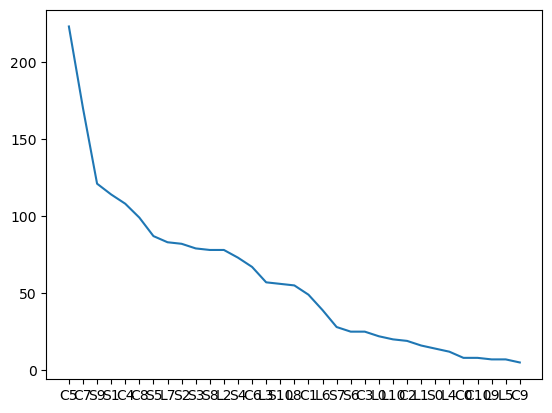

In [50]:
#Plot the location numbers. 

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plt.plot(df_pol_sh1.iloc[:, [3]].squeeze().value_counts())

In [51]:
#Note that iloc returns a dataframe. 
df_pol_sh1.iloc[:, [3]]

,location_number
0,L4
1,S2
2,S2
3,S2
4,S2
...,...
1929,S1
1930,S1
1931,L1
1932,L1


In [52]:
#Note that loc and normal colunm name calling returns a series. 
df_pol_sh1['location_number']

0       L4
1       S2
2       S2
3       S2
4       S2
        ..
1929    S1
1930    S1
1931    L1
1932    L1
1933    L1
Name: location_number, Length: 1934, dtype: object

In [53]:
#Creating bins, each bin will be a week starting on May 16, 2022, and going for 18 weeks. 
bins = pd.date_range(start='2022-05-15', freq='1W', periods=18)

#Creating A column with the binned categorization. 
df_pol_sh1['binned_week'] = pd.cut(df_pol_sh1['sample_date'], bins = bins)

#Creating series weekly bins, with each bin having an average of the total pollinator 
#visitation for each week, divided by the total number locations that were surveyed for each week.
series_mean = df_pol_sh1['binned_week'].value_counts() / df_pol_sh1.groupby('binned_week')['location_number'].nunique()

<AxesSubplot:>

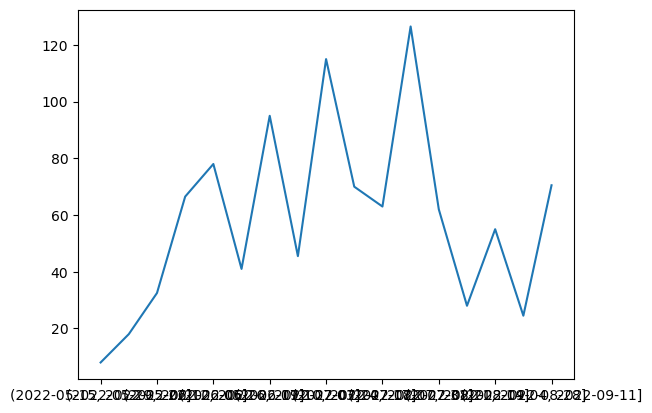

In [54]:
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
series_mean.plot()

In [55]:
series_mean

(2022-05-15, 2022-05-22]      8.0
(2022-05-22, 2022-05-29]     18.0
(2022-05-29, 2022-06-05]     32.5
(2022-06-05, 2022-06-12]     66.5
(2022-06-12, 2022-06-19]     78.0
(2022-06-19, 2022-06-26]     41.0
(2022-06-26, 2022-07-03]     95.0
(2022-07-03, 2022-07-10]     45.5
(2022-07-10, 2022-07-17]    115.0
(2022-07-17, 2022-07-24]     70.0
(2022-07-24, 2022-07-31]     63.0
(2022-07-31, 2022-08-07]    126.5
(2022-08-07, 2022-08-14]     62.0
(2022-08-14, 2022-08-21]     28.0
(2022-08-21, 2022-08-28]     55.0
(2022-08-28, 2022-09-04]     24.5
(2022-09-04, 2022-09-11]     70.5
dtype: float64

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

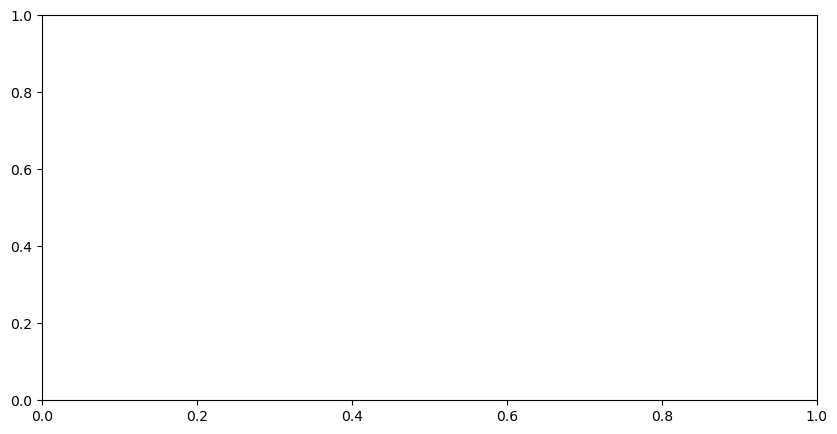

In [56]:
fig, ax1 = plt.subplots(figsize= (10, 5))
ax1.plot(series_mean)

plt.show()

In [59]:
series_mean.index

CategoricalIndex([(2022-05-15, 2022-05-22], (2022-05-22, 2022-05-29],
                  (2022-05-29, 2022-06-05], (2022-06-05, 2022-06-12],
                  (2022-06-12, 2022-06-19], (2022-06-19, 2022-06-26],
                  (2022-06-26, 2022-07-03], (2022-07-03, 2022-07-10],
                  (2022-07-10, 2022-07-17], (2022-07-17, 2022-07-24],
                  (2022-07-24, 2022-07-31], (2022-07-31, 2022-08-07],
                  (2022-08-07, 2022-08-14], (2022-08-14, 2022-08-21],
                  (2022-08-21, 2022-08-28], (2022-08-28, 2022-09-04],
                  (2022-09-04, 2022-09-11]],
                 categories=[(2022-05-15, 2022-05-22], (2022-05-22, 2022-05-29], (2022-05-29, 2022-06-05], (2022-06-05, 2022-06-12], (2022-06-12, 2022-06-19], (2022-06-19, 2022-06-26], (2022-06-26, 2022-07-03], (2022-07-03, 2022-07-10], ...], ordered=True, dtype='category')

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

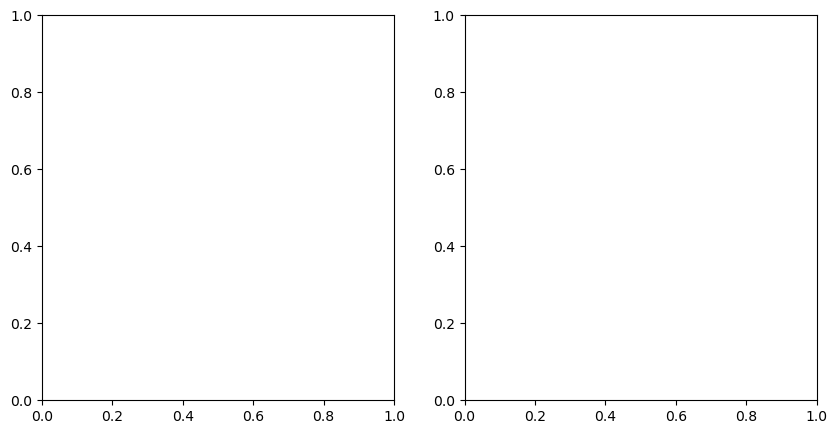

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs[0]
ax.plot(series_mean.index.categories, series_mean.values)